In [440]:
import numpy as np 
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import csv
import math
import struct
%matplotlib inline
import random
import matplotlib.pyplot as plt
import struct
from array import array
from os.path  import join


In [441]:

# Define the transformation to convert the images to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader can be used to create batches of tensors
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [442]:
class Generator(nn.Module):
    def __init__(self, input_dim, hid_dim, image_dim):
        super().__init__()

        #simple feed forward generator with ReLU and sigmoid activation functions
        self.fc_input = nn.Linear(input_dim, hid_dim)
        self.fc_hid1 = nn.Linear(hid_dim, hid_dim)
        self.fc_hid2 = nn.Linear(hid_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, image_dim)
        self.act = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        self.hid_BN = nn.BatchNorm1d(hid_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        out = self.fc_input(x)
        out = self.hid_BN(out)
        out = self.act(out)
        out = self.fc_hid1(out)
        out = self.hid_BN(out)
        out = self.act(out)
        out = self.fc_hid2(out)
        out = self.hid_BN(out)
        out = self.act(out)
        out = self.fc_out(out)
        out = self.sigmoid(out) #forces output to be between [0,1]

        return out
    
    #generator loss fxn
    def loss_function(self, D_g, epoch):
        epsilon = 1e-8
                #minimize the correctness of the generator 
        # loss = -torch.mean(torch.log(D_g + epsilon))
    
        # loss = torch.mean(torch.log(1 - D_g + epsilon))

        #* CHANGE TO BCELOSS
        fake_target = torch.ones_like(D_g) * 0.95
        loss = F.binary_cross_entropy(D_g, fake_target)

        return loss
    

class Discriminator  (nn.Module):
    def __init__(self, image_dim, hid_dim, output_dim= 1):
        super().__init__()

        #simple feed forward network discriminator with dropout
        self.fc_input = nn.Linear(image_dim, hid_dim)
        self.fc_hid1 = nn.Linear(hid_dim, hid_dim)
        self.fc_hid2 = nn.Linear(hid_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.act = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        out = self.act(self.fc_input(x))
        out = self.dropout(out)
        out = self.act(self.fc_hid1(out))
        out = self.dropout(out)
        out = self.act(self.fc_hid2(out))
        out = self.dropout(out)
        out = self.sigmoid(self.fc_out(out))

        return out
    

    #discriminator loss fxn

    def loss_function(self, D_g, D_x):
        epsilon = 1e-8

        #maximize the probability that the data is real
        # loss = -torch.mean(torch.log(D_x + epsilon) + torch.log(1 - D_g + epsilon)) #negative sign because we are doing gradient ASCENT

        #*CHANGING TO BCE LOSS
        fake_target = torch.zeros_like(D_g) + 0.05
        real_target = torch.ones_like(D_x) * 0.95

        fake_loss = F.binary_cross_entropy(D_g, fake_target) #we want D_g to go to zero
        real_loss = F.binary_cross_entropy(D_x, real_target) #we want D_x to go to one

        loss = fake_loss + real_loss

        return loss 

INPUT_DIM = 100
GEN_HIDDEN_DIM = 400
DISC_HIDDEN_DIM = 300
IMAGE_DIM = 28*28


generator = Generator(INPUT_DIM, GEN_HIDDEN_DIM, IMAGE_DIM)
discriminator = Discriminator(IMAGE_DIM, DISC_HIDDEN_DIM)

In [443]:
from torch.optim.lr_scheduler import StepLR


disc_lr = 1e-3
gen_lr = 1e-4

gen_optimizer = torch.optim.Adam(generator.parameters(), lr= gen_lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr= disc_lr)


# scheduler_G = StepLR(gen_optimizer, step_size=30, gamma=0.1)
# scheduler_D = StepLR(disc_optimizer, step_size=10, gamma=0.1)

gen_trn_loss = []
disc_trn_loss = []
gen_val_loss = []
disc_val_loss = [] 

In [411]:
EPOCHS = 15
k = 3

#! CHANGE TO DCGAN 



for epoch in range(EPOCHS):
    gen_trn_run = 0.0
    disc_trn_run = 0.0
    gen_val_run = 0.0
    disc_val_run = 0.0

    for i in range(k):
        for batch_idx, (train_data, train_target) in enumerate(train_loader):
            discriminator.train()
            generator.train()
            gen_optimizer.zero_grad()  

            disc_optimizer.zero_grad()

            batch_size = train_data.shape[0]

            real_data = train_data.view(batch_size, -1)

            noise = torch.randn(batch_size, INPUT_DIM)
            fake_data = generator(noise)

            real_prob = discriminator(real_data)
            fake_prob = discriminator(fake_data)

            disc_loss = discriminator.loss_function(fake_prob, real_prob) 
            gen_loss = generator.loss_function(fake_prob, epoch)


            disc_loss.backward()
            disc_optimizer.step()

            
            if batch_idx % k == 0:
                noise = torch.randn(batch_size, INPUT_DIM)
                fake_data = generator(noise)
                real_prob = discriminator(real_data)
                fake_prob = discriminator(fake_data)
                gen_loss = generator.loss_function(fake_prob, epoch)

                gen_loss.backward()
                gen_optimizer.step()

            disc_trn_run += disc_loss.item()
            gen_trn_run += gen_loss.item()


    
    gen_trn_loss.append(gen_trn_run)
    disc_trn_loss.append(disc_trn_run)

    print(f"EPOCH {epoch + 1}/{EPOCHS}: Disc train loss: {disc_trn_run / len(train_loader):.4f}, Gen train loss: {gen_trn_run / len(train_loader):.4f} ")


EPOCH 1/15: Disc train loss: 1.2405, Gen train loss: 8.5059 
EPOCH 2/15: Disc train loss: 1.2399, Gen train loss: 8.4927 
EPOCH 3/15: Disc train loss: 1.2455, Gen train loss: 8.4926 


KeyboardInterrupt: 

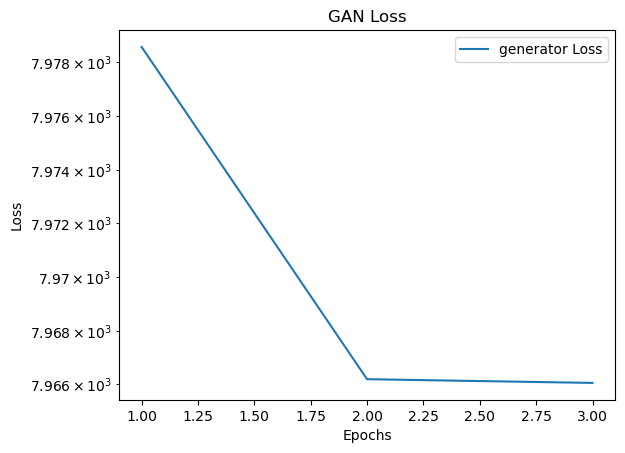

In [412]:
plt.figure()
plt.yscale('log')
epochs = range(1, len(gen_trn_loss)+ 1)   # Assuming one loss value per epoch

# Plotting the training and validation loss
plt.plot(epochs, gen_trn_loss, label='generator Loss')
# plt.plot(epochs, disc_trn_loss, label='discriminator Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Loss')
plt.legend()

# Display the plot
plt.show()

torch.Size([64, 784])


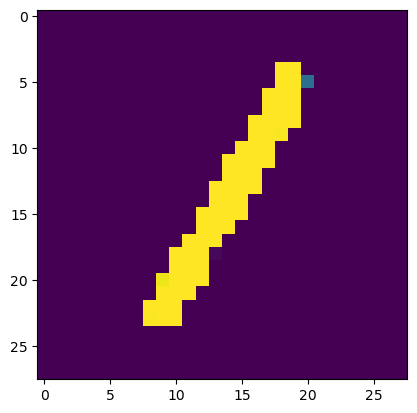

In [437]:
discriminator.eval()
generator.eval()

batch_size = 64

noise = torch.randn(batch_size, INPUT_DIM)
with torch.no_grad():
    logits = generator(noise)
print(logits.shape)
logits = logits.view(batch_size,28,28)

plt.imshow(logits[20])